# 图像半色调(Halftoning)

假设一幅灰度图像，那么我们知道它的每个像素都有一个对应的灰度值，通常这个灰度的取值范围是 0 ~ 255，即 8 bit 灰度级。而半色调技术的意思就是，如图中所示，将灰度级压缩，划分成 10 个灰度级，取值范围是 0 ~ 9。我们想将以前的图像的一个像素，用现在的一个 3 * 3的矩阵表示，它在原图像中的像素值是一个 0 ~ 255 的数， 在 0 ~ 255 内10等分，即像素灰度值除以25.6，则其像素值就会对应图中的某一种情况，那么就用那个矩阵来表示这个像素。比如灰度是 0， 那么那个像素就用图中 0 的情况的矩阵表示。

In [1]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from scipy.misc import imread, imresize, imsave

In [2]:
src = cv2.cvtColor(cv2.imread('../datas/rgb-cube.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

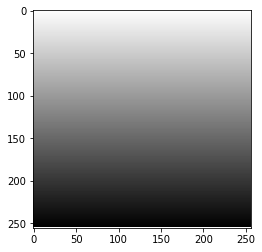

In [3]:
size = 256
# 生成256*256灰度图像
simple_gray = np.zeros((size,size),dtype=np.uint8)
for i in range(size):
    simple_gray[i,:] = (255 - i - 1) * np.ones((1,size))

plt.imshow(simple_gray,'gray')

In [9]:
# 基于半色调计数的图像打印
rows,cols = gray.shape
#将256灰度级量化成10灰度级别
qim = np.fix(np.float32(simple_gray) / 25.6)
new_gray = gray.copy()

# 调整图像大小
r_scale = float(rows) / 272
c_scale = float(cols) / 352

scale = max(r_scale,c_scale)
if scale > 1:
    new_gray = cv2.resize(new_gray,(int(cols * 1.0 / scale),int(rows * 1.0 / scale)))
cy,cx = new_gray.shape                     

# 构造点模式，表示10个灰度级
dot_mat = np.array([[[0,0,0],[0,0,0],[0,0,0]],
[[0,255,0],[0,0,0],[0,0,0]],
[[0,255,0],[0,0,0],[0,0,255]],
[[255,255,0],[0,0,0],[0,0,255]],
[[255,255,0],[0,0,0],[255,0,255]],
[[255,255,255],[0,0,0,],[255,0,255]],
[[255,255,255],[0,0,255,],[255,0,255]],
[[255,255,255],[0,0,255],[255,255,255]],
[[255,255,255],[255,0,255],[255,255,255]],
[[255,255,255],[255,255,255],[255,255,255]]])

dst = np.zeros((3 * cy,3*cx),np.float32)

for i in range(1,cy):
    for j in range(1,cx):
        level = qim[i,j]
        
        dst[int((i - 1) * 3 + 1):int(i * 3),int((j - 1) * 3):int(j * 3)] = dot_mat[:,:,level + 1]
plt.imshow(dst)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [12]:
print(dot_mat[:,:,2])

[[  0   0   0]
 [  0   0   0]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [255   0 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
